# **Simulation-Based Inference**

**Note:** This notebook is the short one that we will go through in class. The full version of the notebook, with all the methods and more details is the `SBI_full.ipynb`.

In [1]:
# --- Compatibility patch for GetDist + NumPy 2.0 ---
# NumPy 2.0 removed np.infty, but older versions of GetDist still use it.
# This patch restores it at runtime before importing GetDist.

import numpy as np
if not hasattr(np, 'infty'):
    np.infty = np.inf  # Restore deprecated alias for compatibility

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import basinhopping
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from scipy.stats import norm
from getdist import plots, MCSamples
from scipy.integrate import quad
import multiprocessing
from multiprocessing import Pool

In [4]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from sbi.inference import SNPE
from sbi.utils.torchutils import BoxUniform

2025-11-12 13:16:11.854093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762953371.867645 3414328 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762953371.871681 3414328 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762953371.882679 3414328 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762953371.882691 3414328 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762953371.882693 3414328 computation_placer.cc:177] computation placer alr

In [5]:
%matplotlib inline

In [6]:
torch.__version__

'2.7.0+cu126'

# 1. Introduction

## 1.1. Revisiting Bayesian Inference

The goal of Bayesian inference is given a model and some observed data $x$, to infer the distribution of the model parameters $\theta$ that are consistent with the data, i.e. the posterior distribution $p(\theta|x)$. This is achieved using Bayes' theorem: 
$$ p(\theta|x) = \frac{p(x|\theta)p(\theta)}{p(x)}$$

In astronomy, the observed data $x$ and the respective parameters $\theta$ can be e.g.:

| <center> x </center> | <center> θ </center> |
| --- | --- |
| observed X-ray photon count of a galaxy cluster | the mass of the cluster |
|  gravitational wave signal from a collapsing black hole binary | the mass ratio and ellipticity of the binary |
|  2D sky projection of galaxy weak lensing measurements | the cosmological parameters governing dark matter and dark energy |

<p float="center">
<center>
  <img src="assets/likelihood_prior_posterior.png" width="500" />
  <img src="assets/prior_lh_post.png" width="300" /> 
 </center> 
</p>

<small> 

<i>Figure 1 (Top):</i> Example of Bayesian inference with a prior distribution, a posterior distribution, and a likelihood function. Taken from https://doi.org/10.3389/fncom.2019.00002 .

<i>Figure 2 (Bottom):</i> The prior, likelihood and posterior distributions for an arbitrary 1D inference problem. Given an observed data point $x_0$ (in black), we want to infer the posterior constraints on the model parameter $\theta$. Taken from https://doi.org/10.48550/arXiv.2402.05137 .

</small>


### 1.1.1. Let's first remind ourselves of what the Likelihood function is:
The likelihood function quantifies how likely the <span style="color:#d87c3a">*observed data*</span> is, given a set of <span style="color:#d87c3a">*model parameters*</span>, that describe our theory. Essentially, the likelihood is what we know about how the data was generated, and it describes this probabilistic process the data went through and how it depends on the model parameters.

Given some data/observations $x$, generated through some stochastic process, we can sometimes <span style="color:#d87c3a">*construct*</span> a likelihood function that describes the probability of observing the data given some parameters $\theta$. 

Normally, we derive the analytical form of the likelihood function from the <span style="color:#d87c3a">theory</span>, combined with some <span style="color:#d87c3a">assumptions about the noise</span> in the data or <span style="color:#d87c3a">unknown physics</span> (e.g. assume Gaussian distribution for continuous data, Poisson distribution for count data).

### 1.1.2. The limits of traditional inference:
What we have described so far is the traditional Bayesian inference, where we write down an *analytical* form of the likelihood. Afterwards, we can sometimes analytically compute the posterior distribution (if the evidence term is tractable)
or use sampling methods (e.g. MCMC) to sample from it.

However, we often encounter complex systems where the underlying processes are not fully understood or are too complicated to model analytically &rarr; <span style="color:#d87c3a">for a general inference problem, we may not know which likelihood function to choose or whether this choice is valid.</span>

**So, what happens when we cannot write down an analytical form of the likelihood?**

<details>
<summary><span style="color:red"> <b>[Spoiler]</b> (click here to expand)</span></summary>
We can resort to...
<img src=assets/sponge_bob.jpg width=400>
</details>


## 1.2. Simulators

Simulators are <span style="color:#d87c3a">computer programs that generate synthetic data from a model</span>. They take as **input** a set of parameters $\theta$, sample a series of internal states or **latent variables**, $z_i \sim p(z_i | z_{<i}, \theta)$, and then **generate** a data vector $x \sim p(x | z, \theta)$.

In astronomy, some examples of simulators are:
- **N-body simulations**: simulate the evolution of a system of particles under the influence of gravity.
- **Galaxy formation simulations**: simulate the formation and evolution of galaxies.
- **Stellar population synthesis**: simulate the spectral energy distribution of a stellar population.

The **latent variables** $z$ can be:
- **physical quantities** that are not directly observable (e.g. position of a particle in an N-body simulation).
- **non-physical quantities** that are internal to the simulator, and do not have a direct physical interpretation (e.g. some internal state).

<center><img src="assets/lfi_sim_green.png" width="800">

<small> <i>Figure 3:</i> The simulator takes as input the model parameters $\theta$ and generates synthetic data $x$. We can view the simulator as a black box function that can be used to generate data for any set of parameters. </small></center>
</center>




The question is: 

***How can we use simulations to perform inference?***

## 1.3. Simulation-based inference: The basic idea
Instead of trying to analytically evaluate the likelihood, we can build a **forward model** of the data &rarr; the stochastic **simulator** becomes the physical **model**.

The <span style="color:#d87c3a">outputs of the simulator</span> are this way <span style="color:#d87c3a">samples of the observational data</span> that we would expect to observe given the parameters $\theta$. 

So, if we simulate enough examples, we can measure the *frequency* of examples that are similar to the observed data, which is the <span style="color:#d87c3a">same as sampling from the likelihood function</span>!

This way, we can:
- bypass the need to evaluate the likelihood analytically
- fully exploit the information content of the data
- incorporate complex physical models, and systematic effects
- combine multiple probes via joint simulations

<center>
<img src="assets/meme_problem_solved.webp" width="400" />
</center>

***So why hasn't this been mainstream until now?***

### 1.3.1 The challenge of simulation-based inference
The probability of a simulation run depends jointly on the observation and the *stochastic latent variables* $z$ of the simulator: $p(x,z | \theta)$. 

However, <span style="color:#d87c3a"> we only observe the data</span> $x$, so the likelihood we need should be marginalized over the latent variables: $$p(x | \theta) = \int p(x,z | \theta) dz = \int p(x | z, \theta) p(z | \theta) dz$$

This is an <span style="color:#d87c3a">integral over all possible trajectories</span> through the latent space (i.e. all possible execution traces of the simulator). For realistic simulators, with large latent spaces, it is not feasible to evaluate this integral explicitly.

⮕ **the marginal likelihood is intractable!**


<center>
<img src="assets/sbi.png" width="800" />

<small> <i>Figure 4:</i> The simulation-based inference (SBI) framework. The simulator is used to generate synthetic data $x \sim p(x | \theta)$ for a range of parameters $\theta$. However, doing inference in this setting is challenging because the likelihood function is intractable. Image credit: Siddharth Mishra-Sharma.
 </small>
</center>



So, how do we deal with this?

A variety of algorithms:
<center><img src="assets/sbi_methods.png" />

<small> <i>Figure 5:</i> Different simulation-based inference methods. Taken from https://doi.org/10.48550/arXiv.2101.04653 .</small>

</center>

In this version of the notebook, we will cover the first (ABC) and the third (NPE) methods. For the other two methods, you can refer to the extended version of the notebook `SBI_full.ipynb`.

# 2. **Example**: Supernova Lumonisity Distance

<div style="border:1px solid black; padding: 10px">

We'll consider a simplified model for the luminosity distance to supernovae, which depends on the cosmological parameters $\Omega_m$ (matter density parameter) and $H_0$ (Hubble constant).

**Key concepts:**
- **Luminosity distance $d_L$**: the distance at which an object of a given luminosity would appear as bright as the object being studied. For a flat universe, ($\Omega_k = 0$), it can be approximated using the cosmological parameters.
- **Apparent magnitude $m$**: the brightness of a supernova. It is related to its luminosity distance.

For simplicity, we'll assume the following:
1. We have a set of supernovae with <span style="color:#d87c3a">observed apparent magnitudes</span> $m_{\text{obs}}$ and <span style="color:#d87c3a">redshifts</span> $z$.

2. The <span style="color:#d87c3a">theoretical apparent magnitude</span> $m_{\text{th}}$ is given by the <span style="color:#d87c3a">distance modulus</span> $\mu$:
$$ \mu = 5 \log_{10}(d_L) + 25, \tag{1}$$
where $d_L$ is the <span style="color:#d87c3a">luminosity distance</span>.

3. The <span style="color:#d87c3a">luminosity distance</span> $d_L$ depends on the <span style="color:#d87c3a">cosmological parameters</span> $\Omega_m$ and $H_0$.


Given the redshift $z$, the <span style="color:#d87c3a">luminosity distance</span> $d_L$ can be approximated by:
$$d_L = \frac{c(1+z)}{H_0} \int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + (1-\Omega_m)}}, \tag{2}$$
where $c$ is the speed of light.

The problem that we will be solving is to <span style="color:red">*infer the cosmological parameters $\Omega_m$ and $H_0$ given the observed apparent magnitudes $m_{\text{obs}}$ and redshifts $z$ of the supernovae.*</span>
</div>


# 3. Standard Bayesian Inference
Let's first try to solve this problem using standard Bayesian inference. We'll assume that the observed apparent magnitudes $m_{\text{obs}}$ have <span style="color:#d87c3a">Gaussian errors</span>, and therefore, we can write down the likelihood function as a <span style="color:#d87c3a">Gaussian over the observed data</span> given the parameters $\Omega_m$ and $H_0$:
$$\mathcal{L}(\Omega_m, H_0) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp\left(-\frac{(m_{\text{obs},i} - m_{\text{th},i})^2}{2\sigma_i^2}\right), \tag{3}$$
where $N$ is the number of supernovae, $m_{\text{obs},i}$ is the observed apparent magnitude of supernova $i$, $m_{\text{th},i}$ is the theoretical apparent magnitude of supernova $i$, and $\sigma_i$ is the error in the observed apparent magnitude of supernova $i$.

First, we need to make up some <span style="color:#d87c3a">mock observed data</span>. We'll assume that the redshifts $z$ of the supernovae are known and generate the observed apparent magnitudes $m_{\text{obs}}$ using the theoretical apparent magnitudes $m_{\text{th}}$ and adding Gaussian noise:
$$ \left\{z, H_0, \Omega_m \right\} \xrightarrow{(2)} d_L \xrightarrow{(1)} m_{\text{th}} \xrightarrow{} m_{\text{obs}} = m_{\text{th}} + \mathcal{N}(0, \sigma^2).$$

So let's make a function that calculates the luminosity distance given the redshift and cosmological parameters:

In [7]:
# Luminosity distance function
def luminosity_distance(z, Omega_m, H0):
    """ Calculate the luminosity distance for a given redshift, Omega_m and H0 """
    integrand = lambda z_prime: 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + (1 - Omega_m))
    d_L = np.array([quad(integrand, 0, z_i)[0] for z_i in z])
    return (c * (1 + z) * d_L) / H0

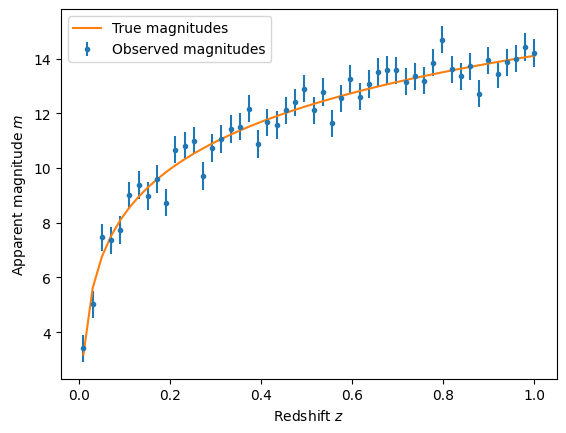

In [8]:
#random seed
np.random.seed(1234)
torch.manual_seed(1234)

# Constants
c = 299792.458  # Speed of light in km/s

# True cosmological parameters
true_Omega_m = 0.3
true_H0 = 70.0  # Hubble constant in km/s/Mpc

# Redshifts of the supernovae
z = np.linspace(0.01, 1.0, 50)

# Noise level in the observed magnitudes
sigma = 0.5

# Generate synthetic data
d_L_true = luminosity_distance(z, true_Omega_m, true_H0)
m_true = 5 * np.log10(d_L_true / 10)
m_obs = m_true + np.random.normal(0, sigma, len(m_true))  # Adding Gaussian noise

# Plot synthetic data
plt.errorbar(z, m_obs, yerr=0.5, fmt='.', label='Observed magnitudes')
plt.plot(z, m_true, label='True magnitudes')
plt.xlabel('Redshift $z$')
plt.ylabel('Apparent magnitude $m$')
plt.legend()
plt.show()


We will consider a <span style="color:#d87c3a">uniform prior</span> for $ 0 < \Omega_m < 1$ and $50 < H_0 < 100$, the likelihood function in Eq. $(3)$, and the posterior from the Bayes theorem.

In [8]:
# Log-prior function
def log_prior(params):
    Omega_m, H0 = params
    if 0 < Omega_m < 1 and 50 < H0 < 100:
        return 0
    else:
        return -np.inf
    
# Define the log-likelihood function
def log_like(params, z, m_obs):
    Omega_m, H0 = params
    d_L = luminosity_distance(z, Omega_m, H0)
    m_th = 5 * np.log10(d_L / 10)
    sigma_m = 0.5  # Assumed standard deviation of magnitudes
    return -0.5 * np.sum(((m_obs - m_th) / sigma_m)**2)    

# Log-posterior function
def log_post(params, z, m_obs):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(params, z, m_obs)

Now, we just need to sample from the posterior using MCMC to get the posterior distribution of the parameters $\Omega_m$ and $H_0$.

In [9]:
# Sampling with `emcee` 
ndim, nwalkers = 2, 16
ncpus = multiprocessing.cpu_count()

# Initialize walkers around a random position withing the prior volume
pos = np.random.uniform([0, 50], [1, 100], (nwalkers, ndim))

with Pool(ncpus) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(z, m_obs), pool=pool)
    sampler.run_mcmc(pos, 3000, progress=True)

100%|██████████| 3000/3000 [00:30<00:00, 98.53it/s] 


<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:7: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:7: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_2700471/2052069056.py:5: SyntaxWarning: invalid escape sequence '\O'
  samples = MCSamples(samples=flat_samples, names=['\Omega_m', 'H_0'], labels=['\Omega_m', 'H_0'])
/tmp/ipykernel_2700471/2052069056.py:5: SyntaxWarning: invalid escape sequence '\O'
  samples = MCSamples(samples=flat_samples, names=['\Omega_m', 'H_0'], labels=['\Omega_m', 'H_0'])
/tmp/ipykernel_2700471/2052069056.py:7: SyntaxWarning: invalid escape sequence '\O'
  g.triangle_plot(samples, filled=True, markers={'\Omega_m': true_Omega_m, 'H_0': true_H0})


Removed no burn in


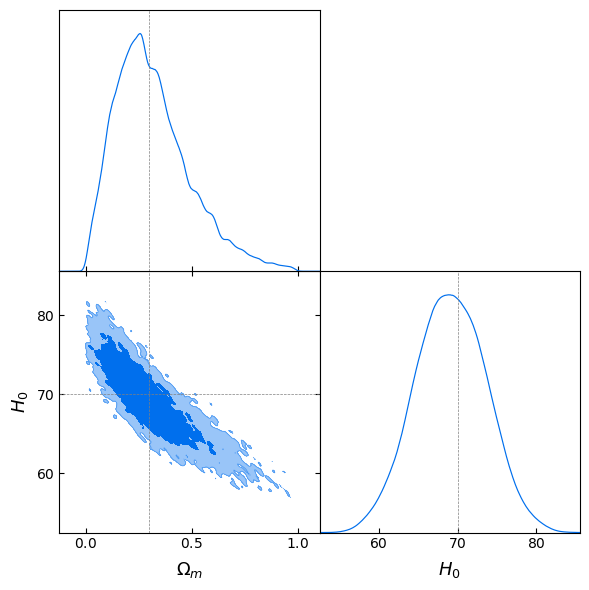

In [10]:
# Get samples and convert to GetDist MCSamples
flat_samples = sampler.get_chain(discard=1000, flat=True)

# GetDist plotting
samples = MCSamples(samples=flat_samples, names=['\Omega_m', 'H_0'], labels=['\Omega_m', 'H_0'])
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(samples, filled=True, markers={'\Omega_m': true_Omega_m, 'H_0': true_H0})
plt.show()

# 4. Simulation-based Inference

Now, let's try to solve the same problem using different simulation-based inference methods. To do this, we'll first need to construct a <span style="color:#d87c3a">simulator for the luminosity distance to supernovae</span>.

In [9]:
# noise level
sigma = 0.5

# Forward model to simulate observed magnitudes
def luminosity_distance_simulator(params, z):
    Omega_m, H0 = params
    d_L = luminosity_distance(z, Omega_m, H0)
    m_th = 5 * np.log10(d_L / 10)
    m_sim = m_th + np.random.normal(0, sigma, len(m_th))
    return m_sim

This very simple simulator uses the theoretical model for the luminosity distance given by Eq. $(2)$ and $(1)$ to generate the theoretical apparent magnitudes $m_{\text{th}}$ for a given set of cosmological parameters $\Omega_m$ and $H_0$, and adds Gaussian noise to generate the observed apparent magnitudes $m_{\text{obs}}$.

## 4.1. Traditional SBI - Approximate Bayesian Computation (ABC)

The first simulation-based inference method we'll use is ABC. ABC was one of the first simulation-based inference methods developed and is based on the idea of <span style="color:#d87c3a">approximating the posterior</span> distribution by <span style="color:#d87c3a">sampling from the prior</span> distribution and <span style="color:#d87c3a">accepting samples that are "close enough" to the observed data</span>.

General procedure:
1. **Sample** parameters from the prior distribution $\theta \sim p(\theta)$.
2. **Forward simulate** these parameters to generate **synthetic observations** $x \sim p(x | \theta)$.
3. **Compare** the synthetic observations to the real observed data $x_{\text{obs}}$ using a distance metric $d(x, x_{\text{obs}})$.
4. If the synthetic observations are "close enough" to the real observed data, i.e., $d(x, x_{\text{obs}}) < \epsilon$ for some threshold $\epsilon$, **accept the parameters** $\theta$ as samples from the posterior $p(\theta | x_{\text{obs}})$.

ABC does not require the likelihood function to be known, instead the likelihood is approximated by the probability that the condition $d(x, x_{\text{obs}}) < \epsilon$ is satisfied.

As the <span style="color:#d87c3a">threshold</span> $\epsilon \to 0$, the <span style="color:#d87c3a">accepted samples converge to the true posterior</span>. For $\epsilon > 0$, the inferred posterior will be <span style="color:#d87c3a">broader than the true posterior</span>, therefore the inference will be <span style="color:#d87c3a">conservative</span>.

<center><img src="assets/abc.png" width="800" />

<small> <i>Figure 6:</i> Approximate Bayesian computation (ABC) algorithm. The simulator is used to generate synthetic data $x \sim p(x | \theta)$ for a range of parameters $\theta$. The distance function $d(x, x_{\text{obs}})$ is used to compare the synthetic data to the observed data. Image credit: Siddharth Mishra-Sharma.
 </small>
</center>

Let's now try to apply ABC to our problem of inferring the cosmological parameters $\Omega_m$ and $H_0$ from supernova data. As a distance metric, we'll use the mean squared error (MSE), $d(x, x_{\text{obs}}) = \frac{1}{N} \sum_{i=1}^N (x_i - x_{\text{obs},i})^2$, between the observed apparent magnitudes $m_{\text{obs}}$ and the synthetic apparent magnitudes $m_{\text{th}}$.

In [12]:
# Distance metric: Mean Squared Error
def mse(x, x_sim):
    return np.sum((x - x_sim) ** 2) / len(x)

# ABC Algorithm
def abc(y, x, eps_thresh=0.5, num_samples=1000):
    """ Approximate Bayesian Computation (ABC) algorithm """
    accepted_samples = []
    trials = 0
    progress_bar = tqdm(total=num_samples, desc=f"Accepted Samples (eps={eps_thresh})")

    while len(accepted_samples) < num_samples:
        params = np.random.uniform(low=[0, 50], high=[1, 100])  # θ ~ p(θ) (Step 1)
        x_sim = luminosity_distance_simulator(params, y)  # x ~ p(x|θ) (Step 2)
        eps = mse(x, x_sim)  # Distance metric; d(x, x_sim) (Step 3)
        trials += 1

        # If accepted, add to samples (Step 4)
        if eps < eps_thresh:
            accepted_samples.append(params) 
            acceptance_ratio = len(accepted_samples) / trials 
            progress_bar.update(1)
            progress_bar.set_postfix(acceptance_ratio=f"{acceptance_ratio:.3f}")

    progress_bar.close()
    
    return np.array(accepted_samples)

We will run the ABC algorithm for two different values of $\epsilon$: $0.4$ and $0.6$.

In [13]:
# Run ABC
eps_thresh = [0.4, 0.6]

# Run ABC for each epsilon threshold
results = {}
for eps in eps_thresh:
    results[eps] = abc(z, m_obs, eps_thresh=eps, num_samples=1000)

Accepted Samples (eps=0.4):   1%|          | 6/1000 [00:00<00:33, 29.38it/s, acceptance_ratio=0.049]

Accepted Samples (eps=0.6): 100%|██████████| 1000/1000 [00:03<00:00, 267.63it/s, acceptance_ratio=0.372]


Removed no burn in
Removed no burn in


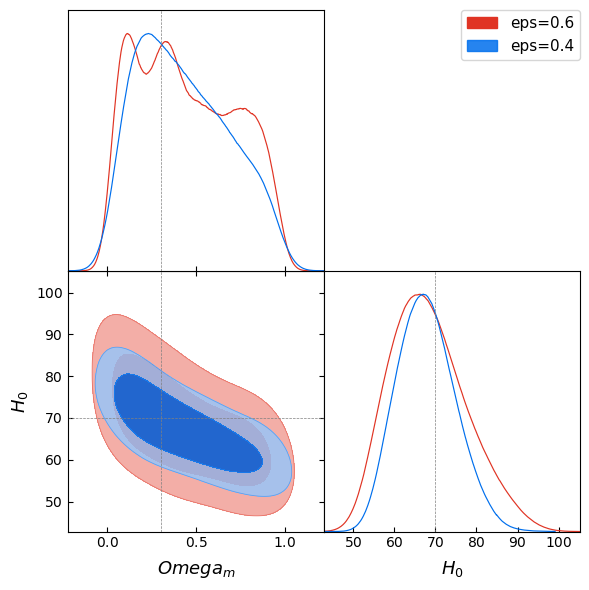

In [14]:
# GetDist plotting
samples1 = MCSamples(samples=results[0.6], names=['Omega_m', 'H0'], labels=['Omega_m', 'H_0'])
samples2 = MCSamples(samples=results[0.4], names=['Omega_m', 'H0'], labels=['Omega_m', 'H_0'])

g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples1, samples2], filled=True, markers={'Omega_m': true_Omega_m, 'H0': true_H0}, legend_labels=[f"eps={eps_thresh[1]}", f"eps={eps_thresh[0]}"])
plt.show()

<font size=3><u>**In-class discussion: What can you see from the plot?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><span style="color:red"> <b>[Spoiler]</b> (click here to expand)</span></summary>
<br>
We see that first of all, the posteriors that we get from ABC are reasonably close to the "true" posterior that we got from standard Bayesian inference. However, as expected, the posteriors from ABC are broader than the true posterior, because of the relatively large values of ε that we used, and indeed, the bigger the ε, the broader the posterior.
</details>

<font size=3><u>**In-class discussion: What do you think are the main drawbacks of ABC?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><span style="color:red"> <b>[Spoiler]</b> (click here to expand)</span></summary>
<br>

- We need to <span style="color:#d87c3a">choose a distance metric</span> that is appropriate for the problem.
- We have an <span style="color:#d87c3a">extra hyperparameter</span> to tune: the threshold ε.
- Small values of ε <span style="color:#d87c3a">require unfeasibly many simulations</span>, while large values lead reduced accuracy.
- The sample efficiency of ABC <span style="color:#d87c3a">scales poorly to high-dimensional</span> data x and high-dimensional parameters θ.
- Inference for new data or different choice of prior requires <span style="color:#d87c3a">re-running the entire algorithm</span>.
</details>

## 4.2. Neural Posterior Estimation (NPE)

This method is a Deep Learning implementation of ***density estimation***: given a set of points $\{x\} \sim \mathcal{P}(x)$, we want to learn the distribution $\mathcal{P}(x)$.

The way that we would normally do this for inference is by creating a model for the likelihood via estimating the distribution of the simulated data using <span style="color:#d87c3a">histograms</span> or <span style="color:#d87c3a">kernel density estimation</span>. However, these methods are not very flexible and **do not scale well to high-dimensional data** (curse of dimensionality).

This is where recent advances in <span style="color:#d87c3a">density estimation techniques using neural networks</span> come in. 

<!-- add dashed line --> 
>To understand how neural networks can be used for density estimation, let's first consider a simple example where we want to estimate the **distribution** over $\theta$, in the case when this distribution is a 1D Gaussian. Here, we can use a neural network to model the mean and variance of the Gaussian as a function of some input $x$:
>$$ p(\theta | x) = \mathcal{N}\big(\mu = f(x), \sigma = g(x)\big),$$
>where $f(x)$ and $g(x)$ are the outputs of the neural network. The neural network will be trained to maximize the likelihood of this predicted Gaussian over the training data by tuning the parameters of $f$ and $g$.

However, in general, we do not expect the posterior to be Gaussian. In this case, we can use a more general neural network architecture to model the posterior.
One class of these neural density estimation methods is **Normalizing Flows**.

### 4.2.1. Interlude: Normalizing Flows
Normalizing Flows are <span style="color:#d87c3a">invertible transformations</span> of the probabilistic space that allows to <span style="color:#d87c3a">map a simple distribution to a more complex one</span>.

<center> <img src="assets/normalizing-flow.png" width="800" /> 

<small> <i>Figure 7:</i> Illustration of a normalizing flow model, transforming a simple distribution $p_0(z_0)$ (left) to a complex one $p_K(z_K)$ (right) through a series of invertible transformations $f_k$. Image credit: Lilian Weng.
 </small>
</center>

The key idea behind Normalizing Flows is to start with a <span style="color:#d87c3a">simple base distribution</span> $\pi(\mathbf{u})$ (e.g. a standard normal) and **transform** it through a series of <span style="color:#d87c3a">invertible transformations</span> $f$ (bijections) to obtain a more <span style="color:#d87c3a">complex target distribution</span> $p(\mathbf{u})$. This is formalized using the change of variables formula:
$$ \mathbf{z} \sim \pi(\mathbf{u}), \quad \mathbf{x} = f(\mathbf{u}), \quad \mathbf{u} = f^{-1}(\mathbf{x}) $$
$$ p(\mathbf{x}) = \pi(\mathbf{u}) \left| \det \frac{d\mathbf{u}}{d\mathbf{x}} \right| = \pi(f^{-1}(\mathbf{x})) \left| \det \frac{df^{-1}(\mathbf{x})}{d\mathbf{x}} \right|$$

where $f^{-1}$ is the inverse transformation of $f$, and the Jacobian determinant $\left| \det \frac{df^{-1}(\mathbf{x})}{d\mathbf{x}} \right|$ accounts for the change in volume when transforming from $\mathbf{u}$ to $\mathbf{x}$ space. The Jacobian ensures that the transformation is <span style="color:#d87c3a">volume-preserving</span>, so that the transformed density $p(\mathbf{x})$ integrates to 1. So Normalizing Flows allow constructing expressive distributions by composing simple, invertible transformations.

The challenge is in designing mappings $f$ that are both: **easy to invert** and **easy to compute the Jacobian of**.

<center> 
<img src="assets/forward.gif" /> 

<small> The NF transforms the simple base distribution to the target distribution by applying a series of invertible transformations one after the other. Image credit: Eric Jang.
</small> 
</center> 

<details>
<summary><span style="color:red">Training a Normalizing Flow <em>(Open at your own risk)</em> </span></summary>

#### Training

Normalizing Flows are trained to **maximize the likelihood of training data $x$ under the transformed distribution $p(x)$**. This is equivalent to minimizing the Kullback-Leibler divergence between the data and model distributions.

> **Kullback-Leibler (KL) divergence** measures the difference between two probability distributions $p(x)$ and $q(x)$:
> $$ D_{KL}(p||q) = \mathbb{E}_{p(x)}\left[\log \frac{p(x)}{q(x)}\right] = \int p(x) \log \frac{p(x)}{q(x)} dx.$$
> The KL divergence is non-negative and is zero if and only if $p(x) = q(x)$.
> Minimizing the KL divergence is equivalent to maximizing the likelihood of the data under the model distribution.

So let's see exactly how we would train a Normalizing Flow to estimate the posterior $p(\theta | x)$. So far, we have the tools to emulate a probability distribution with a neural network. We'll write such a probability distribution $q_\phi$ where $\phi$ are the parameters of the neural network. 

A way to learn the distribution $p(\theta | x)$ with a Neural Network with weights $\phi$ is to minimize $D_{KL}\Big(p(\theta | x) || q_\phi(\theta | x)\Big)$ w.r.t.the NN parameters $\phi$. Let's do the math:
$$ D_{KL}\Big(p(\theta | x) || q_\phi(\theta | x)\Big) = \mathbb{E}_{p(\theta | x)}\left[\log \frac{p(\theta | x)}{q_\phi(\theta | x)}\right] $$
However, we want our model to work for different values of $x$, so we need to take the expectation of this expression w.r.t. $p(x)$:

\begin{align*}
\mathbb{E}_{p(x)} \Big[ D_{KL}\big(p(\theta | x) || q_\phi(\theta | x)\big) \Big] &= \mathbb{E}_{p(x)}\mathbb{E}_{p(\theta | x)}\left[\log \frac{p(\theta | x)}{q_\phi(\theta | x)}\right] = \mathbb{E}_{p(\theta,x)}\left[\log \frac{p(\theta | x)}{q_\phi(\theta | x)}\right] \\\\
&= \mathbb{E}_{p(\theta,x)} \left[ - \log q_\phi(\theta | x)\right] + \mathrm{const}_{w.r.t. \phi}
\end{align*}

where in the second equality we used $p(\theta,x) = p(\theta | x)p(x)$.
Therefore, to optimize our neural network, we need to minimize:
$$ \min_\phi \mathbb{E}_{p(x)} \Big[ D_{KL}\big(p(\theta | x) || q_\phi(\theta | x)\big) \Big] = \min_\phi \mathbb{E}_{p(\theta,x)} \left[ - \log q_\phi(\theta | x)\right] + \cancel{\mathrm{const}_{w.r.t. \phi}}$$
which we can estimate since we have samples from $p(\theta,x)$ from the simulator!

<center>
<img src="assets/monty_python.gif" width="400px" />
</center>

</details>

Once we have trained the Normalizing Flow, we can sample the model $q_\phi(\theta | x_{\text{obs}})$ directly to obtain samples from the approximate posterior distribution $p(\theta | x_{\text{obs}})$. To do this, we simply sample $z$ from the base distribution (e.g. a standard normal) and apply the inverse transformation $f^{-1}$ to obtain samples from the posterior.

#### Normalizing Flows summary:
1. Start from a <span style="color:#d87c3a">simple base distribution</span> that is easy to sample from and evaluate the density of, like a standard normal.

2. Apply a <span style="color:#d87c3a">sequence of invertible transformations</span> to this base distribution. Each transformation is designed to be efficient to compute and have a tractable Jacobian.

3. The transformed distribution at the end of this sequence of transformations is the <span style="color:#d87c3a">final Normalizing Flow distribution</span>. It can be much more complex and expressive than the base distribution.

4. <span style="color:#d87c3a">Sampling</span> from the Normalizing Flow is <span style="color:#d87c3a">efficient</span> - just sample from the base distribution and pass it through the sequence of transformations. <span style="color:#d87c3a">Evaluating the density of a point</span> is also <span style="color:#d87c3a">tractable</span> using the change of variables formula.

5. The transformations are <span style="color:#d87c3a">parameterized</span> by <span style="color:#d87c3a">neural networks</span> and <span style="color:#d87c3a">trained to maximize the likelihood of observed data</span>. This allows learning complex, data-driven distributions.

> If you want to learn more about Normalizing Flows, you can check out the paper by [Papamakarios et al. (2019)](https://arxiv.org/abs/1912.02762) and the blog post by [Lilian Weng](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html).

### 4.2.2. Back to NPE

Now that we are OK with Normalizing Flows, let's see the specifics of how we can use them for Neural Posterior Estimation.
The steps of the algorithm are:
1. **Generate training data**: Sample a large number of parameter values $\theta$ from the prior, run the simulator to generate corresponding data $x$, and store the $(\theta, x)$ pairs as training data.

2. [Optional] **Feature extraction**: Extract features from the data $x$ using a neural network $s_\varphi(x)$. This is useful when the data $x$ is high-dimensional or complex, and we want to reduce its dimensionality or complexity. What the NN does is essentially to learn a compressed representation of the data that is useful for the inference task. For now, you can forget about this and just consider $s_\varphi(x) = x$.

3. **Training the conditional density estimator**: 
    - evaluate the log-density of the NF, $\log q_\phi(\theta | x)$, at the training data points $(\theta, x)$.
    - wiggle the parameters $\phi$ of the NF until the log-likelihood of the training data is maximized.
    - the exact loss function is: $$\mathcal{L}(\phi, \varphi) = -\frac{1}{N} \sum_{i=1}^N \log q_\phi(\theta_i | s_\varphi(x_i)),$$ where $N$ is the number of training samples, and $\{ \phi, \varphi \}$ are the parameters of the NF and the feature extractor, respectively.
    
4. **Inference**: To perform inference for new data $x_{\text{obs}}$, just sample from the NF model $q_\phi(\theta | x_{\text{obs}})$ to obtain samples from the posterior distribution $p(\theta | x_{\text{obs}})$!

<center>
<img src="assets/npe.png" width="800" />

<small> <i>Figure 8:</i> Neural Posterior Estimation (NPE) algorithm. The simulator is used to generate synthetic data $x$ for a range of parameters $\theta$. The NF is trained to model the posterior distribution $p(\theta | x)$ conditioned on the training data. Image credit: Siddharth Mishra-Sharma.
 </small>

</center>

### 4.2.3. Applying NPE to our problem

To use SBI methods like NPE, we can leverage existing libraries that implement these algorithms.
Those can make your life much easier, and you can use them to perform SBI without having to make everything from scratch. Some of the most popular libraries are:
- [`sbi`](https://github.com/mackelab/sbi)
- [`pydelfi`](https://github.com/justinalsing/pydelfi)
- [`ltu-ili`](https://github.com/maho3/ltu-ili)

Let's see how easy things can be using e.g. the `sbi` library. We just need to take our simulated pairs of $(\theta, x)$ and choose an SBI method. So let's do it with NPE:

#### Sample generation

This method is based on Neural Networks, and to train them, we need to generate a large number of samples from the simulator. So let's sample from the prior distribution of the parameters $\theta$ and then simulate the data $x$ for each of these parameters:

In [21]:
np.random.seed(1234) # use random seed for reproducibility

# Generate training data
n_train = 20_000
param_samples = np.random.uniform(low=[0, 50], high=[1, 100], size=(n_train, 2)) # Parameter proposal
x_samples = np.array([luminosity_distance_simulator(theta, z) for theta in tqdm(param_samples)])

# Convert to tensors
param_samples = torch.tensor(param_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

100%|██████████| 20000/20000 [00:23<00:00, 854.94it/s]


Check one of the generated samples:

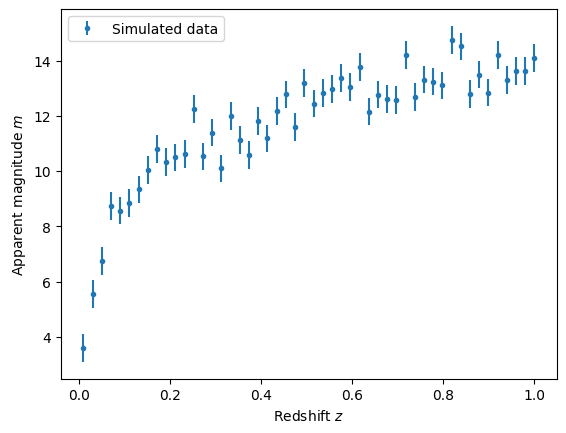

In [22]:
# plot the training data
plt.errorbar(z, x_samples[42], yerr=sigma, fmt='.', label='Simulated data')
plt.xlabel('Redshift $z$')
plt.ylabel('Apparent magnitude $m$')
plt.legend()
plt.show()

#### NPE class

Now the important part: we will define our SBI model that will learn the posterior distribution $p(\theta | x)$.
> It will be trying to model the distribution of the *parameters* $\theta$ given the *data* $x$.

In [23]:
prior = BoxUniform(low=torch.tensor([0.0, 50.0]), high=torch.tensor([1.0, 100.0]))
# Define the SBI model and give it the prior
inference = SNPE(prior=prior)
# append the parameter-simulation pairs
inference.append_simulations(param_samples, x_samples)
# train() the density estimator
density_estimator = inference.train()

# build posterior using the trained density estimator
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 38 epochs.

<div style="background-color: #F0FFF0; border: 2px solid #C0DCC0; padding: 15px; border-radius: 5px;">

⚠️ NOTE: in the newer versions of `sbi`, the API has changed a bit. So the cell above would look like this:

```python
import sbi
from sbi.inference import NPE

inference = NPE()
inference.append_simulations(param_samples, x_samples).train()
posterior = inference.build_posterior()
```

</div>

We have trained the Normalizing Flow model to estimate the posterior distribution $p(\theta | x)$ given **any** observed data $x$! We can now sample from this model to obtain samples from the posterior distribution for $\Omega_m$ and $H_0$.

#### Inference

So let's generate a mock observed data $x_{test} = x_{\text{obs}}$ and sample from the model to obtain samples from the posterior distribution $p(\theta | x_{\text{obs}})$. <span style="color:#d87c3a">Don't get confused</span> - in a real application, $x_{\text{obs}}$ would be the <span style="color:#d87c3a">actual observed data</span>, and we would use the model to infer the posterior distribution of the parameters $\theta$ given this data.

In [24]:
# Test the trained model
param_test = np.array([0.3, 70.0])
x_obs = luminosity_distance_simulator(param_test, z) # assume that the observed data "comes from" the above parameters

Nice, now we can just sample from the posterior distribution using the trained model, conditioned on the observed data $x_{\text{obs}}$, and make the corner plot of the posteriors:

<>:11: SyntaxWarning: invalid escape sequence '\O'
<>:11: SyntaxWarning: invalid escape sequence '\O'
<>:15: SyntaxWarning: invalid escape sequence '\O'
<>:11: SyntaxWarning: invalid escape sequence '\O'
<>:11: SyntaxWarning: invalid escape sequence '\O'
<>:15: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_3414328/684273537.py:11: SyntaxWarning: invalid escape sequence '\O'
  gd_samples_npe = MCSamples(samples=samples_npe, labels=['\Omega_m', 'H_0'], names=['\Omega_m', 'H_0'])
/tmp/ipykernel_3414328/684273537.py:11: SyntaxWarning: invalid escape sequence '\O'
  gd_samples_npe = MCSamples(samples=samples_npe, labels=['\Omega_m', 'H_0'], names=['\Omega_m', 'H_0'])
/tmp/ipykernel_3414328/684273537.py:15: SyntaxWarning: invalid escape sequence '\O'
  g.triangle_plot([gd_samples_npe], filled=True, markers={'\Omega_m': true_Omega_m, 'H_0': true_H0}, legend_labels=['NPE', 'MCMC'])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


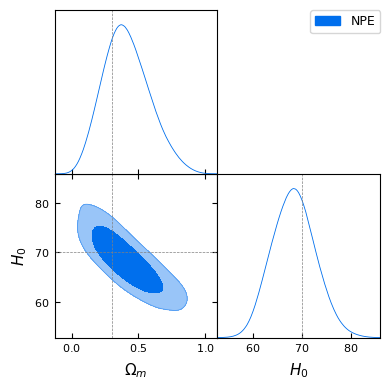

In [26]:
samples_npe = posterior.sample((10000,), x=x_obs)

# Convert to numpy (ensure on CPU and detached from graph)
if isinstance(samples_npe, torch.Tensor):
    samples_npe = samples_npe.detach().cpu().numpy()
else:
    samples_npe = np.asarray(samples)


# Create a getdist MCSamples object
gd_samples_npe = MCSamples(samples=samples_npe, labels=['\Omega_m', 'H_0'], names=['\Omega_m', 'H_0'])

# Make a triangle/contour plot with getdist
g = plots.get_subplot_plotter()
g.triangle_plot([gd_samples_npe], filled=True, markers={'\Omega_m': true_Omega_m, 'H_0': true_H0}, legend_labels=['NPE', 'MCMC'])

We see that the posteriors that we get from NPE are very similar to the "true" posterior that we got from standard Bayesian inference!

<center>
<img src="assets/almost_too_easy.gif" width="400px" />
</center>

But be careful, sometimes things can go wrong , so you may have to look in the details of the code of the library, change stuff, and all those horrible things that you don't want to do. But now you know how everything works under the hood, so you can do it!

## What if we wanted to make everything from scratch?

*Let's see what happens behind the scenes...*

In [20]:
np.random.seed(1234) # use random seed for reproducibility

# Generate training data
n_train = 50_000
param_samples = np.random.uniform(low=[0, 50], high=[1, 100], size=(n_train, 2)) # Parameter proposal
x_samples = np.array([luminosity_distance_simulator(theta, z) for theta in tqdm(param_samples)])

# Convert to tensors
param_samples = torch.tensor(param_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

  0%|          | 176/50000 [00:00<00:56, 874.27it/s]

100%|██████████| 50000/50000 [00:58<00:00, 861.85it/s]


We will try to implement NPE from scratch using PyTorch and a Normalizing Flow model.

So for the training data, we will use the same samples that we generated before: pairs of $(\theta, x)$.

In machine learning, it is common to normalize the input data to have zero mean and unit variance (this is done automatically in the `sbi` backage). This helps the neural network to learn more efficiently:

In [21]:
def normalize(data):
    """ Normalizes the data to have mean 0 and standard deviation 1. """
    mean = data.mean(dim=0)
    std = data.std(dim=0)
    return (data - mean) / std, mean, std

In [22]:
# Normalize the training data
x_norm, x_mean, x_std = normalize(x_samples)
param_norm, param_mean, param_std = normalize(param_samples)

#### Featurizer
We will first define a simple MLP, which we will use as the feature extractor $s_\phi(x)$ in the NPE algorithm, to reduce the dimensionality of the data $x$. Again, don't worry too much about this for now, just consider $s_\phi(x) = x$.

In [24]:
def build_mlp(input_dim, hidden_dim, output_dim, num_layers, activation=nn.GELU()):
    """Builds a multi-layer perceptron (MLP) neural network."""
    layers = [nn.Linear(input_dim, hidden_dim), activation]  # First layer and activation
    
    for _ in range(num_layers):
        layers += [nn.Linear(hidden_dim, hidden_dim), activation] # Hidden layers and activations
        
    layers += [nn.Linear(hidden_dim, output_dim)] # Output layer
    
    return nn.Sequential(*layers)

#### NPE class

Now the important part: we will define our conditional Normalizing Flow model that will learn the posterior distribution $p(\theta | x)$.
> The NF will be trying to model the distribution of the *parameters* $\theta$ given the **context** (condition) of the *data* $x$.

In [25]:
class NeuralPosteriorEstimator(pl.LightningModule):
    """
    Neural Posterior Estimator using a normalizing flow as the posterior density estimator.

    Parameters:
        featurizer (nn.Module): Neural network for feature extraction.
        d_context (int): Dimension of the context vector.
    """
    
    def __init__(self, featurizer, d_context=16):
        super().__init__()
        self.featurizer = featurizer # Featurizer network for context extraction
        self.flow = self._build_flow(d_in=2, d_hidden=32, d_context=d_context, n_layers=4) # Normalizing flow
    
    def _build_flow(self, d_in, d_hidden, d_context, n_layers):
        """ Instantiate a normalizing flow with Masked Autoregressive Transformations. """
        base_dist = StandardNormal(shape=[d_in]) # base distribution of NF = standard normal 
        transforms = [] # List to hold the series of transformations
        
        for _ in range(n_layers):
            # Reverse permutation to shuffle the features
            transforms.append(ReversePermutation(features=d_in))
            
            # Masked Autoregressive Transform for flexible and expressive transformations
            transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
            
        # Combine all transformations into a composite transform
        transform = CompositeTransform(transforms)
        
        return Flow(transform, base_dist)    

    def forward(self, x):
        return self.featurizer(x) # Extract features using the featurizer
    
    def loss(self, x, params):
        context = self(x)  # Extract context from x using the featurizer
        return -self.flow.log_prob(inputs=params, context=context) # Compute negative log probability

    def training_step(self, batch):
        x, params = batch 
        loss = self.loss(x, params).mean()  # Compute mean loss
        self.log("train_loss", loss) # Log the training loss
        return loss

    def validation_step(self, batch):
        x, params = batch
        loss = self.loss(x, params).mean() # Compute mean validation loss
        self.log("val_loss", loss) # Log the validation loss
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4) 

Instantiate the featurizer and NeuralPosteriorEstimator

In [26]:
featurizer = build_mlp(input_dim=50, hidden_dim=128, output_dim=16, num_layers=4)
npe = NeuralPosteriorEstimator(featurizer=featurizer, d_context=16)

Create the dataset and dataloader, using the PyTorch DataLoader class:

In [27]:
val_fraction = 0.1 # Fraction of data to use for validation
batch_size = 128 
n_samples_val = int(val_fraction * len(x_norm)) 

dataset = TensorDataset(x_norm, param_norm) 
dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val]) 

train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

Train the model:

In [28]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type       | Params | Mode 
---------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


We have trained the Normalizing Flow model to estimate the posterior distribution $p(\theta | x)$ given **any** observed data $x$! We can now sample from this model to obtain samples from the posterior distribution for $\Omega_m$ and $H_0$.

#### Inference

So let's generate a mock observed data $x_{test} = x_{\text{obs}}$ and sample from the model to obtain samples from the posterior distribution $p(\theta | x_{\text{obs}})$. <span style="color:#d87c3a">Don't get confused</span> - in a real application, $x_{\text{obs}}$ would be the <span style="color:#d87c3a">actual observed data</span>, and we would use the model to infer the posterior distribution of the parameters $\theta$ given this data.

In [29]:
# Test the trained model
param_test = np.array([0.3, 70.0])
x_obs = luminosity_distance_simulator(param_test, z) # assume that the observed data "comes from" the above parameters

x_obs_norm = (torch.Tensor(x_obs) - x_mean) / x_std # normalize the test data
context = npe.featurizer(x_obs_norm).unsqueeze(0)

In [30]:
# Sample from the trained normalizing flow
test_samples = npe.flow.sample(num_samples=10000, context=context) * param_std + param_mean
test_samples = test_samples.detach().numpy().squeeze(0)

<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:2: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_2700471/4026163189.py:2: SyntaxWarning: invalid escape sequence '\O'
  samples = MCSamples(samples=test_samples, labels=['\Omega_m', 'H_0'], names=['Omega_m', 'H_0'])


Removed no burn in


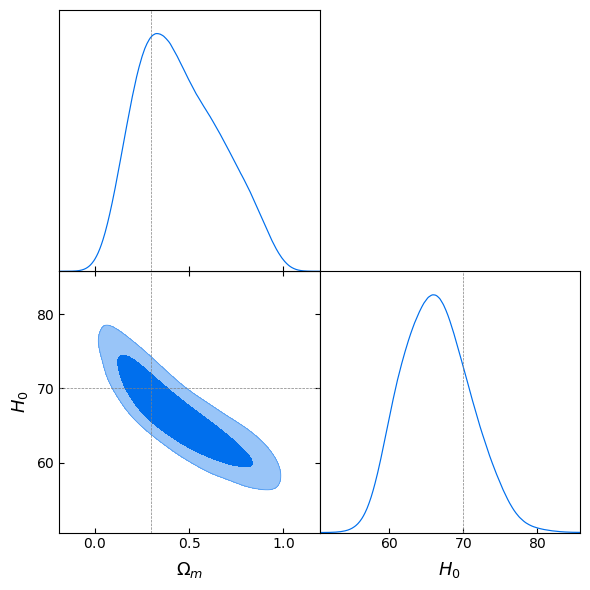

In [31]:
# Create a MCSamples instance
samples = MCSamples(samples=test_samples, labels=['\Omega_m', 'H_0'], names=['Omega_m', 'H_0'])

true_Omega_m = 0.3
true_H0 = 70

# Create a GetDist plot
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples], filled=True, markers={'Omega_m': true_Omega_m, 'H_0': true_H0})
plt.show()

# Conclusion

**Advantages of NPE:**
- No need for a <span style="color:#d87c3a">likelihood</span> function.
- Get direct samples from the <span style="color:#d87c3a">posterior</span>.
- <span style="color:#d87c3a">Flexible posterior modeling</span> with Normalizing Flows.
- <span style="color:#d87c3a">Scalable to high-dimensional</span> data and parameters: Normalizing Flows allow NPE to scale to high-dimensional parameter and data spaces.
- <span style="color:#d87c3a">Amortized inference</span>: Once the NF model is trained on simulated data, it can quickly produce posterior samples for any new observed data $x_{obs}$ through a simple forward pass. This means that we don't need to re-run the inference algorithm for new data.

**Drawbacks of NPE:**
- We must <span style="color:#d87c3a">retrain</span> the model if we want to change the prior.
- If the prior and the posterior are <span style="color:#d87c3a">very different</span>, the model may not be able to capture the posterior distribution well.
- Still, in <span style="color:#d87c3a">high-dimensional spaces</span>, the model may struggle to capture the posterior distribution accurately if we don't have a huge amount of training data.


<center>
<img src="assets/meme_chad_sbi.jpeg" width="800" />
</center>

# Sources & Further Reading


**This notebook is based on the following sources:**
- https://github.com/smsharma/sbi-lecture-mit
- https://astroautomata.com/blog/simulation-based-inference/
- https://github.com/maho3/ltu-ili/tree/main
- https://indico.mitp.uni-mainz.de/event/332/contributions/4532/
- https://indico.cern.ch/event/768915/contributions/3474655/
- https://github.com/glouppe/ssi2023
- https://lilianweng.github.io/posts/2018-10-13-flow-models/
- https://gebob19.github.io/normalizing-flows/
- https://arxiv.org/abs/1911.01429
- https://arxiv.org/abs/2402.05137
- https://arxiv.org/abs/2101.
- https://arxiv.org/abs/2403.14750

**Suggestions for further reading:**

- Blogs and general papers:
    - [Awesome Neural SBI (great list of resources on SBI that is frequently updated)](https://github.com/smsharma/awesome-neural-sbi)
    - [This blog post on Normalizing Flows](https://gebob19.github.io/normalizing-flows/)
    - [This other blog post on Normalizing Flows](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)
    - [This review paper on SBI](https://arxiv.org/abs/1911.01429)
    - [This paper on benchmarking SBI methods](https://arxiv.org/abs/2101.04653)

- Some indicative papers on SBI applications in cosmology and astrophysics:
    - [Fast likelihood-free cosmology with neural density estimators and active learning](https://arxiv.org/abs/1903.00007)
    - [Fast likelihood-free inference in the LSS Stage IV era](https://arxiv.org/abs/2403.14750)
    - [SimBIG: Cosmological Constraints using Simulation-Based Inference of Galaxy Clustering with Marked Power Spectra](https://arxiv.org/abs/2404.04228)
    - [Real-time gravitational-wave science with neural posterior estimation](https://arxiv.org/abs/2106.12594)
    - [Constraining the X-ray heating and reionization using 21-cm power spectra with Marginal Neural Ratio Estimation](https://arxiv.org/abs/2303.07339)
    - [Neural posterior estimation for exoplanetary atmospheric retrieval](https://arxiv.org/abs/2301.06575)
    